In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

## Data analysis
### Labels
- 0: airplane										
- 1: automobile										
- 2: bird										
- 3: cat										
- 4: deer										
- 5: dog										
- 6: frog										
- 7: horse										
- 8: ship										
- 9: truck

In [2]:
((X_train, y_train), (X_val, y_val)) = cifar10.load_data()

In [3]:
def show_image(image, ax=plt):
    ax.imshow(image)

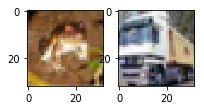

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(3, 3))

show_image(X_train[0], ax[0])
show_image(X_train[1], ax[1])

In [5]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)

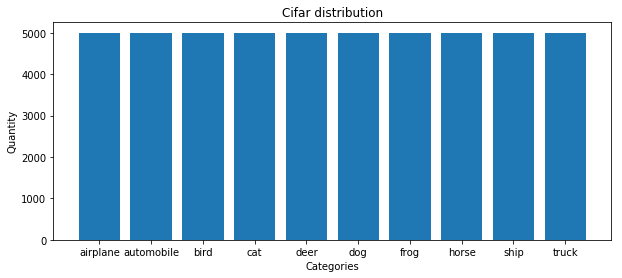

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.bar([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
], counts_elements, )
ax.set_xlabel('Categories')
ax.set_ylabel('Quantity')
ax.set_title('Cifar distribution')
plt.show()

## Data augmentation

In [7]:
def resize_images(images):
    new_images = []
    
    for image in images:
        image = cv2.resize(image, (224, 224))
        new_images.append(image)
    
    return new_images

In [8]:
def rescale_image(image):
    return image / 255.0

def augment_images(images):
    new_images = []
    for image in images:
        new_images.append(rescale_image(image))
    return np.array(new_images)

In [9]:
X_train = augment_images(X_train)
X_val = augment_images(X_val)

In [10]:
encoder = OneHotEncoder(sparse=False)
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)

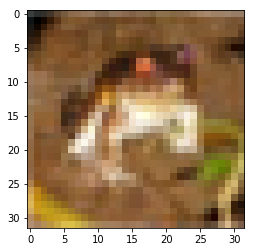

In [11]:
show_image(X_train[0])

## Build model

![VGG16](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [16]:
# VGG16 doesn't work because CPU isn't enough (100%)
# model = Sequential([
# #     224x224
#     Conv2D(filters=64, kernel_size=(3, 3), padding='same', input_shape=(32,32,3)),
#     Conv2D(filters=64, kernel_size=(3, 3), padding='same'),
#     MaxPool2D(),
    
# #     112x112
#     Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
#     Conv2D(filters=128, kernel_size=(3, 3), padding='same'),
#     MaxPool2D(),
    
# #     56x56
#     Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
#     Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
#     Conv2D(filters=256, kernel_size=(3, 3), padding='same'),
#     MaxPool2D(),
    
# #     28x28
#     Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
#     Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
#     Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
#     MaxPool2D(),
    
# #     14x14
#     Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
#     Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
#     Conv2D(filters=512, kernel_size=(3, 3), padding='same'),
#     MaxPool2D(),
    
#     Flatten(),
    
#     Dense(4096),
#     Dense(4096),
#     Dense(10, activation='softmax'),
# ])

model = Sequential([
    Conv2D(96, (11, 11), strides=(4, 4), input_shape=(227, 227, 3)),
    MaxPool2D((3, 3), strides=(2, 2)),
    
    Conv2D(256, (5, 5), padding='same'),
    MaxPool2D((3, 3), strides=(2, 2)),
    
    Conv2D(384, (3, 3), padding='same'),
    Conv2D(384, (3, 3), padding='same'),
    Conv2D(256, (3, 3), padding='same'),
    MaxPool2D((3, 3), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation='relu'),
    Dense(4096, activation='relu'),
    Dense(1000, activation='softmax')
])
model.build()
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 256)      

In [13]:
adam = Adam(lr=5e-4)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                              patience=3, 
                              verbose=1, 
                              factor=0.2, 
                              min_lr=1e-6)

In [ ]:
BATCH_SIZE = 32
EPOCHS = 40

steps_per_epoch = np.shape(X_train)[0]//BATCH_SIZE
validation_steps = np.shape(X_val)[0]//BATCH_SIZE

history = model.fit(X_train,
                   y_train,
                   batch_size=BATCH_SIZE,
                   epochs=EPOCHS,
                   steps_per_epoch=steps_per_epoch,
                   validation_steps=validation_steps,
                   validation_data=(X_val, y_val),
                   callbacks=[reduce_lr])

Train on 50000 samples, validate on 10000 samples
Epoch 1/40


In [ ]:
np.shape(X_train)

In [ ]:
X_train[0][0][0]